In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

from scanning import camera, coordinates, visualization, optimization
import importlib

In [6]:
prime_cam = camera.PrimeCam()
prime_cam.add_module('Mod280', 'c', mod_rot=0)
print(prime_cam.get_module('Mod280').ang_res)

sky_pattern = coordinates.Pong(
    num_term=4, 
    width=3, height=3, spacing='400 arcsec', 
    velocity=1/2, sample_interval=1/400,
    angle=0,
)

telescope_pattern = coordinates.TelescopePattern(
    sky_pattern, obs_param='Observation.json', instrument=prime_cam
)

0.012277667038517641 deg


In [7]:
s = optimization.SimulationChunked(telescope_pattern, 'Mod280', max_acc=0.5)

Running simulation for kept hits...
...0/122441 completed...
...15432/122441 completed...
...30864/122441 completed...
...46296/122441 completed...
...61728/122441 completed...
...77160/122441 completed...
...92592/122441 completed...
...108024/122441 completed...
Running simulation for removed hits...
...0/26893 completed...
...15432/26893 completed...


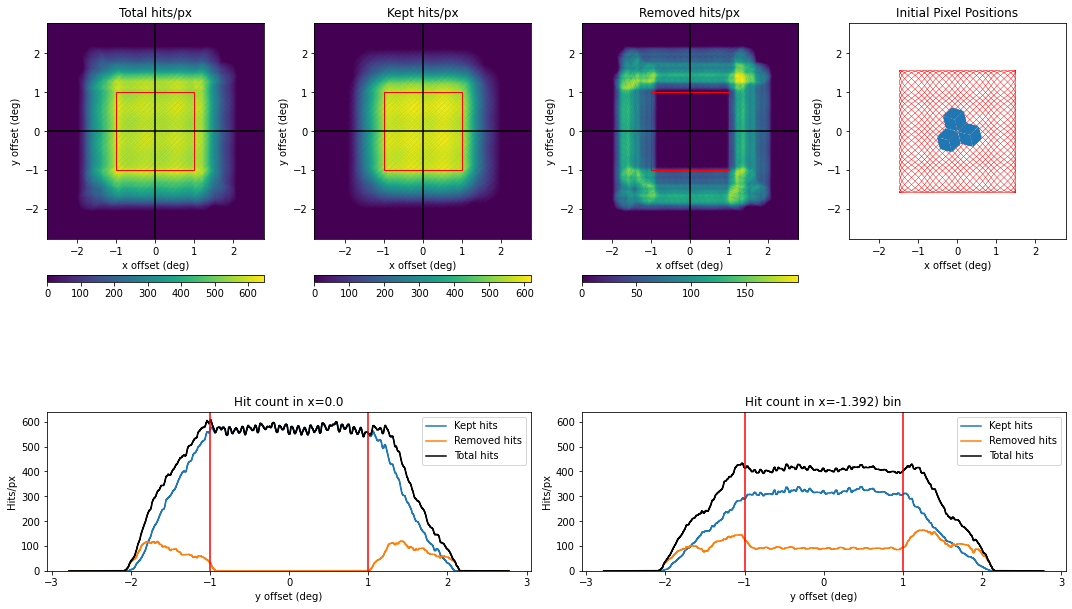

In [8]:
visualization.hm(s, convolve=True)

In [2]:
# Make a TelescopePattern
prime_cam = camera.PrimeCam()
prime_cam.add_module('Mod280', 'i1', mod_rot=0)

# Make a SkyPattern
#daisy_param = {"velocity": 0.3333333333333333, "start_acc": 0.2, "R0": 0.47, "Rt": 0.2222222222222222, "Ra": 0.16666666666666666, "T": 30, "sample_interval": 0.0025, "y_offset": 0.0}
pong_param = {'num_term': 4, 'width': 2, 'height': 2, 'spacing': '500 arcsec', 'velocity': 1/2, 'sample_interval': 1/50}
sky_pattern = coordinates.Pong(**pong_param)

telescope_pattern = coordinates.TelescopePattern(
    sky_pattern, instrument=prime_cam, module='Mod280', 
    start_ra=0, start_dec=0, start_hrang=0
)

In [19]:
importlib.reload(optimization)

<module 'scanning.optimization' from '/home/kristinchengwu/HAA/mapping/scanning/optimization.py'>

In [16]:
importlib.reload(visualization)

<module 'scanning.visualization' from '/home/kristinchengwu/HAA/mapping/scanning/visualization.py'>

In [20]:
s = optimization.Simulation(telescope_pattern, 'Mod280', mem_lim=8*10**7)

Running simulation...
...Done!


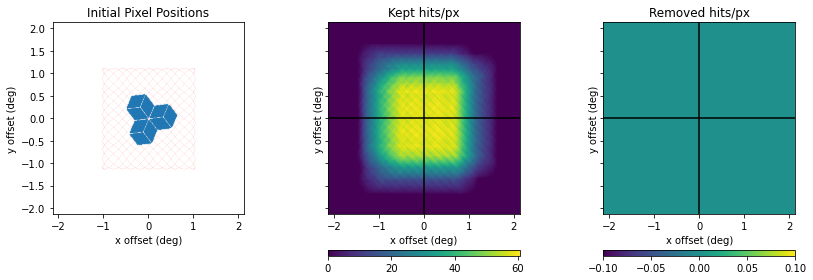

In [21]:
visualization.hitmap(s, kept_hits=True, rem_hits=True)

In [5]:
s.det_hist([(0, 0)])

(array([0, 0, 0, ..., 0, 0, 0]), RangeIndex(start=0, stop=5184, step=1), 1)

1.8769842490483206
2.1233045007200473
1
2


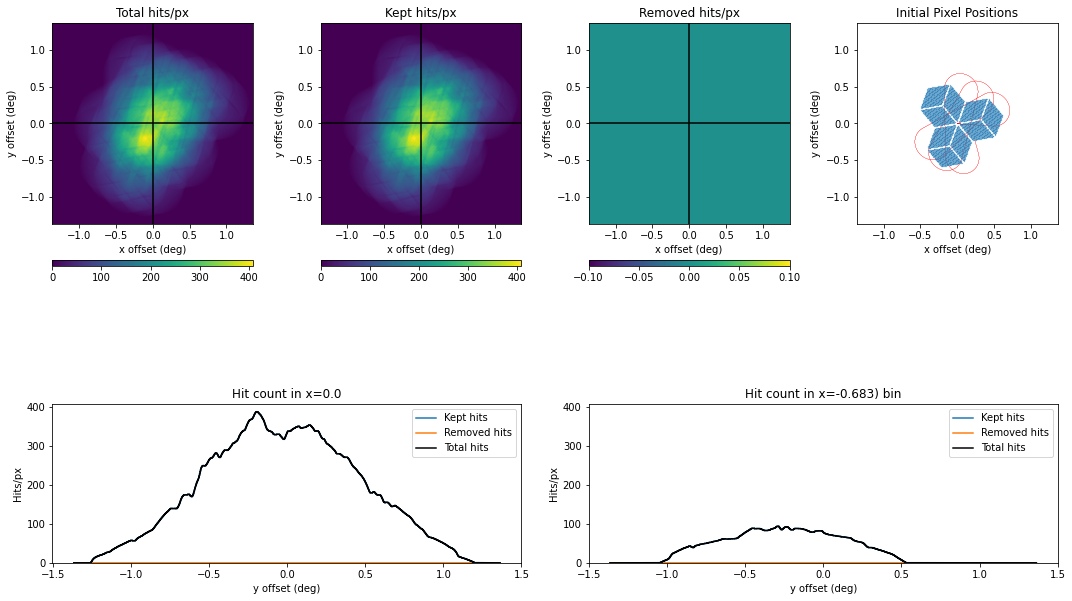

In [28]:
visualization.hitmap(s, convolve=True)

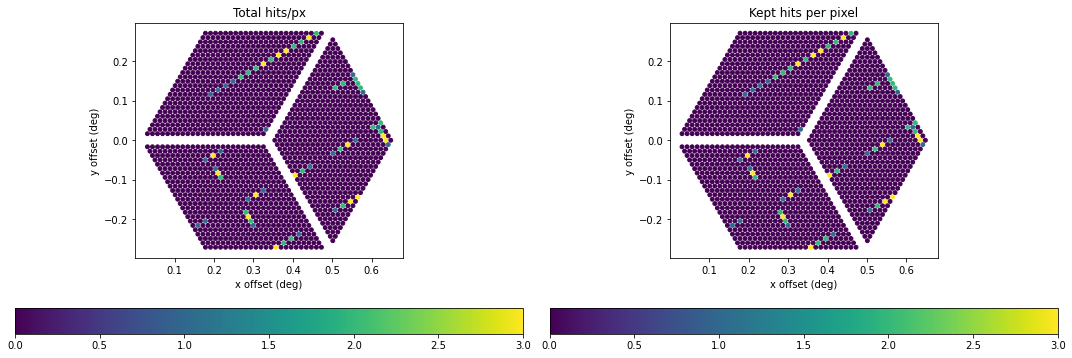

In [5]:
visualization.pxan_det(s, norm_pxan=True)